# Ex. 1) Height Estimation Via Single-View Metrology

## Introduction
Single-view metrology (SVM) is a powerful technique in computer vision that enables the estimation of real-world measurements from a single $2D$ image.

The goal of this study is to estimate the height of a person in an image using projective geometry principles, leveraging a reference object of known height. The approach involves computing vanishing points, constructing the horizon line, and using cross-ratio invariants to determine the correct height-to-pixel ratio.

By leveraging projective geometry, we can compute the unknown height while accounting for the effects of *perspective distortion* – that is, the phenomenon where objects appear smaller as they recede into the distance.


### Scene Description and Image Loading
The image used for this study depicts two people standing on a sidewalk in front of a building. Both individuals are positioned on the same horizontal ground plane but at different distances from the camera.

We refer to the subject in the foreground as to the *reference subject*, while the person on the right, in the background, will be the *target subject* in the present study.

For this study, we assume that the height of the reference subject is known, while the height of the target subject is unknown and will be estimated. We will validate our estimation method by comparing the computed height with the actual known value.

The actual heights of both subjects are:
- $h_{\text{ref}}=170\text{cm}$
- $h_{\text{target}}=162\text{cm}$

---

The process begins by importing necessary libraries and loading the image.

In [1]:
# imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

# change with your current directory
%cd /content/drive/MyDrive/CV\ Assignment\ 1/

Mounted at /content/drive
/content/drive/MyDrive/CV Assignment 1


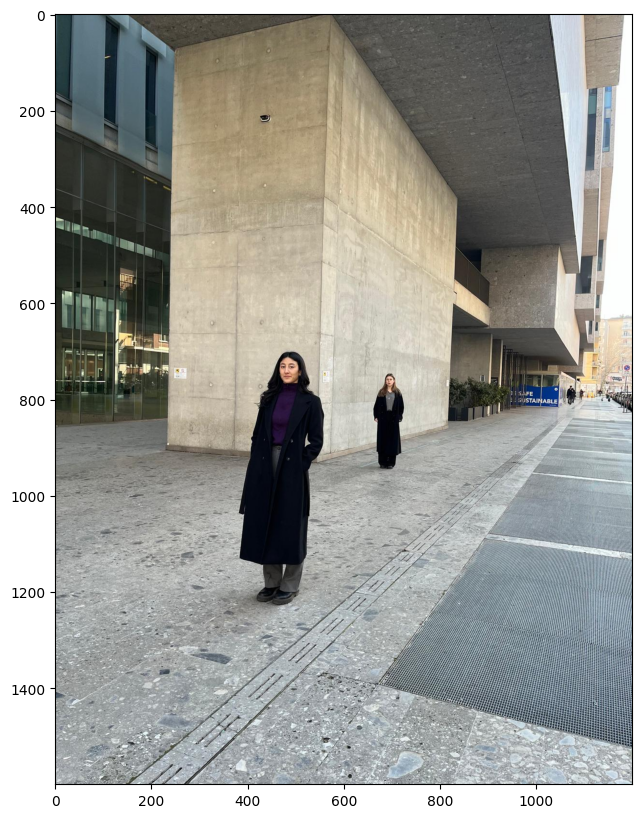

In [ ]:
img = cv2.imread('foto.jpg')[:,:,::-1]
plt.figure(figsize=(15,10))
plt.imshow(img)
plt.show()

## Theoretical Background
### Projective Geometry and Vanishing Points
A **perspective projection** transforms a $3D$ scene into a $2D$ image. Under this transformation, parallel lines in the $3D$ space appear to converge to a point called the **vanishing point** in the image plane.

Key properties:
- In Euclidean geometry, parallel lines never intersect.
- In projective geometry, every pair of lines intersects at some point, even if it is at infinity.
- Any pair of parallel lines in $3D$ world plane $\Pi$ maps to converging lines in the $2D$ image plane $\phi$, meeting at a vanishing point.
- Multiple vanishing points exist corresponding to different sets of parallel lines, as any pair of parallel lines in the $3D$ world space shares the same vanishing point in the image.
- Different planes can define different vanishing points.


In this study, we consider three vanishing points:
1. Vertical vanishing point $(v_{\text{vert}})$;

2. Two horizontal vanishing points $(v_{\text{left}}, v_{\text{right}})$.


The **Horizon line** (or vanishing line) $l_{\text{horiz}}$ is the union of all vanishing points defined for lines parallel to the ground, and can be intended as the intersection of the horizontal plane through the camera center $C$ with the image plane.\
As all points at the same height as $C$ project onto $l_{\text{horiz}}$, the horizon line provides a way of comparing the height of objects in the scene.\
\
In practice, $l_{\text{horiz}}$ will be computed as the line passing through the horizontal vanishing points.

### Cross-Ratio and Perspective Invariance
The *ratio of ratios* or *cross-ratio* is a fundamental invariant under projective transformations.

Given four collinear points $P_1,P_2,P_3,P_4$, the cross-ratio is defined as:

$CR(P_1,P_2,P_3,P_4) = \frac{\|P_3-P_1\| \|P_4-P_2\|}{\|P_3-P_2\| \|P_4-P_1\|}$.

### Homogeneous Coordinates and Normalization
In projective geometry, every point is represented in homogeneous coordinates, where a point $(x, y)$ on the image plane is written as $(x, y, w)$. A homogeneous point is defined up to a scale factor, meaning that multiplying all coordinates by a nonzero scalar results in an equivalent point in the projective space.\
To convert a homogenous point to Cartesian coordinates, we normalize by dividing the first two coordinates by the third:
$P'=(\frac{x}{w},\frac{y}{w})$.

In this implementation, all points are normalized before applying geometric transformations to maintain correctness and scale invariance.

### Intersection of Two Lines and Line Construction
In projective geometry, the intersection of two lines and the line passing through two points are fundamental operations. These can be computed using the cross-product in homogeneous coordinates:

1. Point of intersection of two lines:\
The intersection point of two lines $\ell_1$ and $\ell_2$ is given by their cross-product: $P = \ell_1 \times \ell_2$.\
Since this point is in homogeneous coordinates, it must be normalized to convert it to Cartesian coordinates if it is a finite point.

2. Finding the line passing through two points:\
The equation of a line passing through two points $P_1$ and $P_2$ is also given by the cross-product: $\ell = P_1 \times P_2$.\
This yields the line equation in homogeneous form.

The following functions implement these operations:

In [3]:
def inters_point(line1, line2):
    pt = np.cross(line1, line2)
    if pt[-1] != 0:
        return pt/pt[-1]
    else:
        return pt

def passing_line(pt1, pt2):
    return np.cross(pt1, pt2)

## Geometric Setup Implementation

### Step 1. Annotating Key Points in the Image
We manually mark the top and bottom key points (the head and feet respectively) of both subjects in the image and express them as homogeneous coordinates. This ensures that our computations respect projective transformations.

We denote the key points $(H_{\text{ref}}, F_{\text{ref}})$, $(H_{\text{targ}}, F_{\text{targ}})$, and the image height vectors by tracing the lines joining the heads to the respective feet ($\ell_{\text{ref}}$ and $\ell_{\text{targ}}$, respectively).

In [4]:
H_m = np.array([488.0, 703.0, 1.0])
F_m = np.array([475.53, 1227.021, 1.0])

H_c = np.array([695.0, 748.0, 1.0])
F_c = np.array([688.13, 942.683, 1.0])

line_c = passing_line(H_c, F_c)
line_m = passing_line(H_m, F_m)

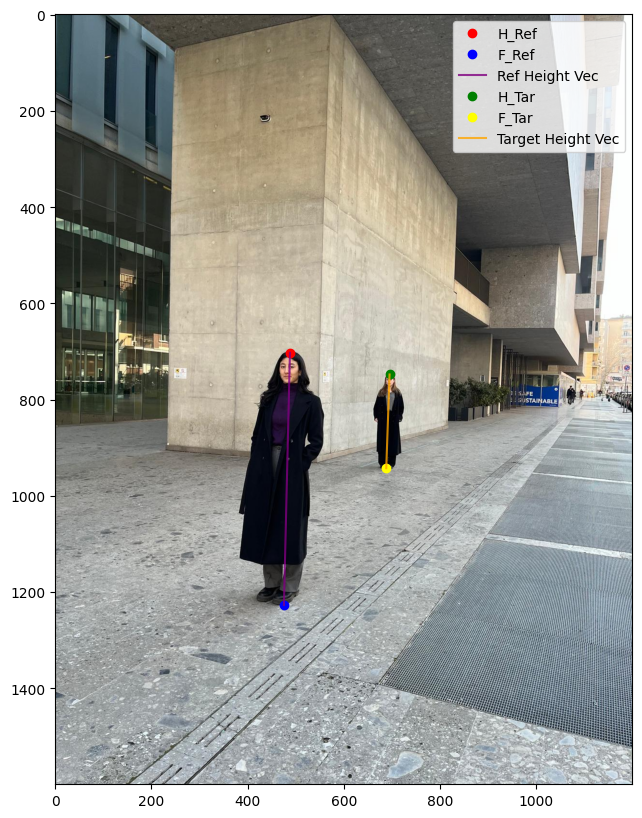

In [5]:
img = cv2.imread('foto.jpg')[:,:,::-1]
plt.figure(figsize=(20,10))

# Martina
plt.plot(H_m[0], H_m[1], 'o', label='H_Ref', color='red')
plt.plot(F_m[0], F_m[1], 'o', label='F_Ref', color='blue')
plt.plot([H_m[0], F_m[0]], [H_m[1], F_m[1]], alpha=0.8, label='Ref Height Vec', color='purple')

# Clara
plt.plot(H_c[0], H_c[1], 'o', label='H_Tar', color='green')
plt.plot(F_c[0], F_c[1], 'o', label='F_Tar', color='yellow')
plt.plot([H_c[0], F_c[0]], [H_c[1], F_c[1]], alpha=0.8, label='Target Height Vec', color='orange')


plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=8)
plt.imshow(img)
plt.legend()
plt.show()

### Step 2: Computing the Vanishing Points
The vanishing points $v_{\text{vert}}$ (vertical), $v_{\text{left}}$, and $v_{\text{right}}$ (horizontal) are the point of intersection of parallel lines (i.e. perpendicular to the ground plane and lying on the ground plane respectively) after being projected onto the $2$-dimensional image plane.

These vanishing points correspond to directions in the scene that appear to converge due to perspective projection.

We apply the same procedure to find them:
- *Select Parallel Lines:*\
We select pairs of lines in the image that correspond to edges of objects known to be parallel in the real-world scene. These lines should ideally extend towards their respective vanishing points.

- *Find Multiple Estimates of the Vanishing Points:*\
Since each pair of parallel lines in $3D$ should ideally intersect at a single vanishing point in $2D$, we compute the intersection points of these lines. These points represent estimates of the vanishing points.

- *Estimate the Vanishing Point using SVD:*\
Since the manually selected lines may contain noise due to inaccuracies in annotation, we apply Singular Value Decomposition (SVD) to the collection of homogeneous line equations to estimate a unique, more robust vanishing point. The vanishing point is then obtained as the right singular vector corresponding to the smallest singular value, ensuring that it best satisfies the constraints imposed by the selected lines.


This method maximizes consistency across the different estimates and minimizes the impact of noise in the data.

#### Vertical Vanishing Point

The first step involves manually annotating points on the image to construct vertical lines. To ensure that they are parallel and orthogonal to the ground in the real world, we obtained them from pillars and edges of the building in the picture.

In [6]:
# vertical line 1
vert_11 = np.array([379,524,1])
vert_12 = np.array([372,886,1])
vert1 = passing_line(vert_11, vert_12)

# vertical line 2
vert_21 = np.array([551,664,1])
vert_22 = np.array([556,436,1])
vert2 = passing_line(vert_21,vert_22)

# vertical line 3
vert_31 = np.array([835,380,1])
vert_32 = np.array([826,601,1])
vert3 = passing_line(vert_31, vert_32)

# vertical line 4
vert_41 = np.array([1036,652,1])
vert_42 = np.array([1046,479,1])
vert4 = passing_line(vert_41,vert_42)


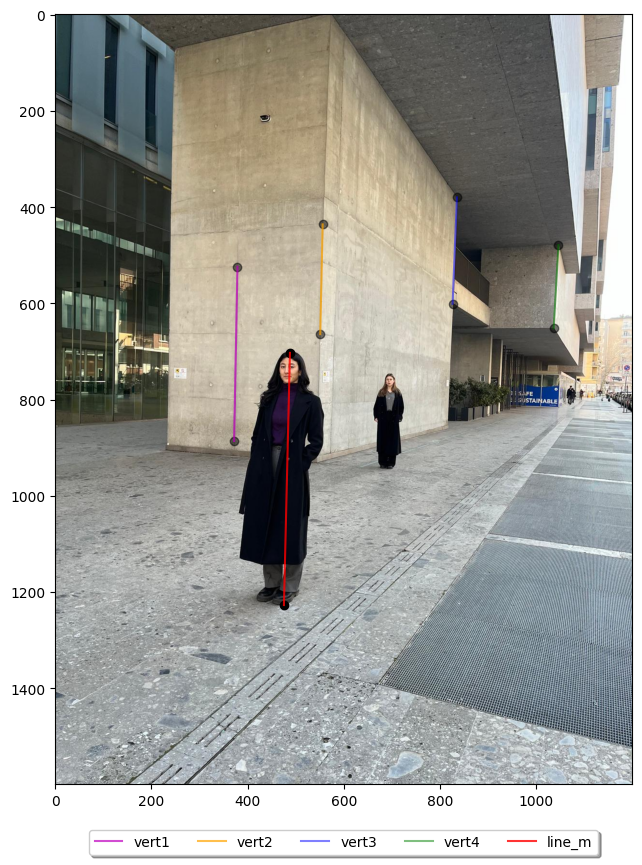

In [7]:
img = cv2.imread("foto.jpg",)[:,:,::-1]
plt.figure(figsize=(20,10))
plt.imshow(img)

plt.plot(vert_11[0], vert_11[1], 'o', alpha=0.5, color='black')
plt.plot(vert_12[0], vert_12[1], 'o', alpha=0.5, color='black')
plt.plot([vert_11[0], vert_12[0]], [vert_11[1], vert_12[1]], 'm', alpha=0.7, label='vert1')

plt.plot(vert_21[0], vert_21[1], 'o', alpha=0.5, color='black')
plt.plot(vert_22[0], vert_22[1], 'o', alpha=0.5, color='black')
plt.plot([vert_21[0], vert_22[0]], [vert_21[1], vert_22[1]], 'orange', alpha=0.7, label='vert2')

plt.plot(vert_31[0], vert_31[1], 'o', alpha=0.5, color='black')
plt.plot(vert_32[0], vert_32[1], 'o', alpha=0.5, color='black')
plt.plot([vert_31[0], vert_32[0]], [vert_31[1], vert_32[1]], 'b', alpha=0.5, label='vert3')

plt.plot(vert_41[0], vert_41[1], 'o', alpha=0.5, color='black')
plt.plot(vert_42[0], vert_42[1], 'o', alpha=0.5, color='black')
plt.plot([vert_41[0], vert_42[0]], [vert_41[1], vert_42[1]], 'g', alpha=0.5, label='vert4')

plt.plot(H_m[0], H_m[1], 'o', color='black')
plt.plot(F_m[0], F_m[1], 'o', color='black')
plt.plot([H_m[0], F_m[0]], [H_m[1], F_m[1]], alpha=0.8, label='line_m', color='red')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=8)
plt.show()

In [8]:
# vanishing points between lines
v1_3 = inters_point(vert1, vert3)
v1_4 = inters_point(vert1, vert4)
v2_4 = inters_point(vert2, vert4)
v1_2 = inters_point(vert1, vert2)
v2_3 = inters_point(vert2, vert3)
v3_4 = inters_point(vert3, vert4)

# using also height vector of Martina to compute the vanishing points
v_new1 = inters_point(line_m, vert1)
v_new2 = inters_point(line_m, vert2)
v_new3 = inters_point(line_m, vert3)
v_new4 = inters_point(line_m, vert4)

We have computed multiple estimates of the vertical vanishing point by intersecting each possible pair of vertical lines considered.

To be able to apply SVD, we put all the lines' coordinates in a matrix so that we can extract the last singular vector as the vector of coordinates of $v_{\text{vert}}$. Moreover, we use $\ell_{\text{ref}}$ for the final vertical vanishing point computation because we assume it's perpendicular to the ground, therefore parallel to the lines we found above. The result is normalized and displayed on the image.

In [9]:
vertical_lines = np.vstack([vert1, vert2, vert3, vert4, line_m])
_, _, vt = np.linalg.svd(vertical_lines)
v_vert = vt[-1,:]

print(f"Vertical vanishing point coordinates before normalization: ({v_vert})")

v_vert = v_vert/v_vert[-1]

print(f"Vertical vanishing point coordinates: ({v_vert[0]:.2f}, {v_vert[1]:.2f})")

Vertical vanishing point coordinates before normalization: ([-2.97264694e-03 -9.99995580e-01 -5.30369474e-05])
Vertical vanishing point coordinates: (56.05, 18854.70)


In a theoretically perfect projective transformation, a true vanishing point should have $w=0$ , meaning that the point is at infinity.
As a matter of fact, our vertical vanishing point (before normalization) has the last coordinate $w$  close to zero, indicating that the vertical lines we found are parallel in the real world. Due to its extreme distance from the image plane, plotting the vertical vanishing point directly on the image would not yield a pleasant visualization. Instead, we adopt a more effective approach:

1.⁠ ⁠Plot all intersection points on a separate graph

2.⁠ ⁠Include the vertical vanishing point computed via Singular Value Decomposition (SVD)

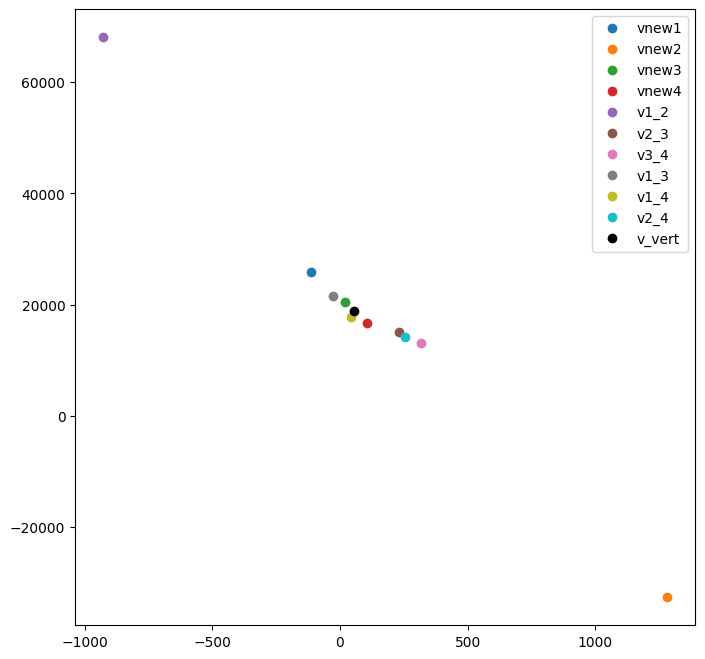

In [10]:
plt.figure(figsize=(8,8))

plt.plot(v_new1[0], v_new1[1], 'o', label='vnew1')
plt.plot(v_new2[0], v_new2[1], 'o', label='vnew2')
plt.plot(v_new3[0], v_new3[1], 'o', label='vnew3')
plt.plot(v_new4[0], v_new4[1], 'o', label='vnew4')


plt.plot(v1_2[0], v1_2[1], "o", label="v1_2")
plt.plot(v2_3[0], v2_3[1], "o", label="v2_3")
plt.plot(v3_4[0], v3_4[1], "o", label="v3_4")


plt.plot(v1_3[0], v1_3[1], "o", label="v1_3")
plt.plot(v1_4[0], v1_4[1], "o", label="v1_4")
plt.plot(v2_4[0], v2_4[1], "o", label="v2_4")
plt.plot(v_vert[0], v_vert[1], "o", color ='k', label="v_vert")
plt.legend()
plt.show()

#### Horizontal Vanishing Points


To compute $v_{\text{left}}$ and $v_{\text{right}}$, the same approach is followed:


In the code, we manually annotate key points in the image, defining sets of parallel lines for both left and right vanishing points.

We manually annotate:
- $4$ pairs of points to construct the left vanishing point $v_{\text{left}}$
- $3$ pairs of points to construct the right vanishing point $v_{\text{right}}$

The code then constructs the collection of parallel lines by computing their equations from selected pairs of points.

In [11]:
## LEFT
left_11, left_12 = np.array([800.0, 1426.0, 1.0]), np.array([1000.0, 1476, 1.0])
left_21, left_22 = np.array([1000.0, 1105.0, 1]), np.array([1050.0, 1112.0, 1])
left_31, left_32 = np.array([1080.0, 965.0, 1.0]), np.array([1120.0, 969.0, 1.0])
left_41, left_42 = np.array([1080.0, 907.0, 1.0]), np.array([1114.0, 909.8, 1.0])

line_l1 = passing_line(left_11, left_12)
line_l2 = passing_line(left_21, left_22)
line_l3 = passing_line(left_31, left_32)
line_l4 = passing_line(left_41, left_42)


## RIGHT
right_11, right_12 = np.array([400.0, 1477.0, 1.0]), np.array([449.0, 1429.3, 1.0])
right_21, right_22 = np.array([400.0, 1389.8, 1.0]), np.array([478.0, 1323.2, 1.0])
right_31, right_32 = np.array([744.0, 1292.7, 1.0]), np.array([777.0, 1247.0, 1.0])

line_r1 = passing_line(right_11, right_12)
line_r2 = passing_line(right_21, right_22)
line_r3 = passing_line(right_31, right_32)


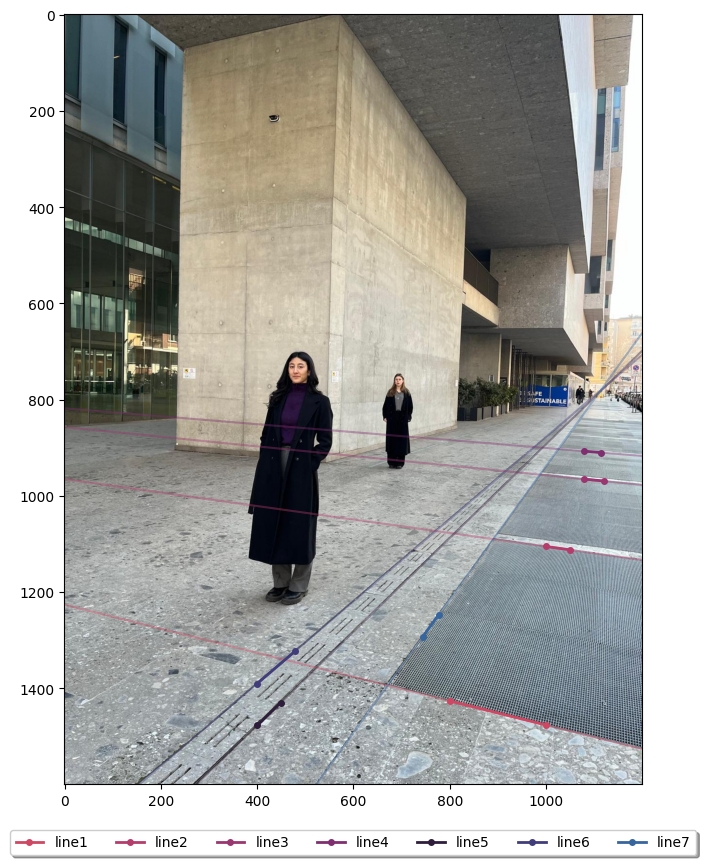

In [12]:
img = cv2.imread('foto.jpg')[:,:,::-1]
plt.figure(figsize=(20,10))
plt.imshow(img)
colors1 = sns.color_palette("flare", n_colors=8)
colors2 = sns.color_palette("mako")

left_lines = [(left_11, left_12, colors1[3], "line1"), (left_21, left_22, colors1[4], "line2"), (left_31, left_32, colors1[5], "line3"), (left_41, left_42, colors1[6], "line4")]
right_lines= [(right_11, right_12, colors2[0], "line5"), (right_21, right_22, colors2[1], "line6"), (right_31, right_32, colors2[2], "line7")]

for p1, p2, color, label in left_lines:
    plt.axline(xy1=(p1[0], p1[1]), xy2=(p2[0], p2[1]), color=color, alpha=0.4)
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], marker='o', ms=4, label=label, color=color, linewidth=2)

for p1, p2, color, label in right_lines:
    plt.axline(xy1=(p1[0], p1[1]), xy2=(p2[0], p2[1]), color=color, alpha=0.4)
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], marker='o', ms=4, label=label, color=color, linewidth=2)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=8)
plt.show()


We now compute the intersection points of each couple of parallel lines. The code iterates through each pair of lines and computes their intersections, yielding multiple estimates for $v_{\text{left}}$ and $v_{\text{right}}$.

The intersection points are stored, and the results are displayed graphically in the code using plots overlaid on the image.

In [13]:
# intersection
v_left_all={}
left_lines = [line_l1, line_l2, line_l3, line_l4]
c = 1
print("Left Intersection Points:")
for i in range(len(left_lines)):
    for j in range(i+1, len(left_lines)):
        x = np.cross(left_lines[i], left_lines[j])
        print(f"v{i+1}{j+1}[-1]= {x[-1]}")
        v_left_all[f"v_left{c}"] = inters_point(left_lines[i], left_lines[j])
        c+=1
print()
print("Normalized:")
for a, x in v_left_all.items():
    print(f"{a}:{x}")

Left Intersection Points:
v12[-1]= -1100.0
v13[-1]= -1200.0
v14[-1]= -1140.000000000009
v23[-1]= -80.0
v24[-1]= -98.00000000000227
v34[-1]= -24.00000000000182

Normalized:
v_left1:[-2.37272727e+03  6.32818182e+02  1.00000000e+00]
v_left2:[-2.46e+03  6.11e+02  1.00e+00]
v_left3:[-2.43333333e+03  6.17666667e+02  1.00000000e+00]
v_left4:[-2.70e+03  5.87e+02  1.00e+00]
v_left5:[-2.54897959e+03  6.08142857e+02  1.00000000e+00]
v_left6:[-2.20666667e+03  6.36333333e+02  1.00000000e+00]


In [14]:
# Right intersection
v_right_all={}
right_lines = [line_r1, line_r2, line_r3]
c = 1
print("Right Intersection Points:")
for i in range(len(right_lines)):
    for j in range(i+1, len(right_lines)):
        x = np.cross(right_lines[i], right_lines[j])
        print(f"v{i+1}{j+1}[-1]= {x[-1]}")
        v_right_all[f"v_right{c}"] = inters_point(right_lines[i], right_lines[j])
        c+=1
print()
print("Normalized:")
for a, x in v_right_all.items():
    print(f"{a}:{x}")

Right Intersection Points:
v12[-1]= 457.200000000008
v13[-1]= -665.2000000000005
v23[-1]= -1366.8000000000065

Normalized:
v_right1:[1.12895538e+03 7.67384252e+02 1.00000000e+00]
v_right2:[1.1100212e+03 7.8581610e+02 1.0000000e+00]
v_right3:[1.11428665e+03 7.79909087e+02 1.00000000e+00]


We have computed multiple estimates of each vanishing point $v_{\text{left}}$ and $v_{\text{right}}$ by intersecting different pairs of lines from the chosen sets.

The code stacks the line equations in a matrix, applies SVD, and extracts the last singular vector as the estimated vanishing point. The result is normalized and displayed on the image.

In [15]:
## V_LEFT
floor_left = np.vstack([line_l1, line_l2, line_l3, line_l4])
_, _, vt = np.linalg.svd(floor_left)
v_left = vt[-1]
print(f"Before normalization:\tv_left= {v_left}")
v_left= v_left/v_left[-1]
print(f"Normalized v_left:\t{v_left}\n")

## V_RIGHT
floor_right = np.vstack([line_r1, line_r2, line_r3])
_, _, vs = np.linalg.svd(floor_right)
v_right = vs[-1]
print(f"Before normalization:\tv_right= {v_right}")
v_right= v_right/v_right[-1]
print(f"Normalized v_right:\t {v_right}")

Before normalization:	v_left= [ 9.68885374e-01 -2.47509540e-01 -3.99418990e-04]
Normalized v_left:	[-2.42573688e+03  6.19673943e+02  1.00000000e+00]

Before normalization:	v_right= [8.19379302e-01 5.73251271e-01 7.35028363e-04]
Normalized v_right:	 [1.11475875e+03 7.79903606e+02 1.00000000e+00]


A visual representation of the estimated vanishing points leveraging SVD is provided:

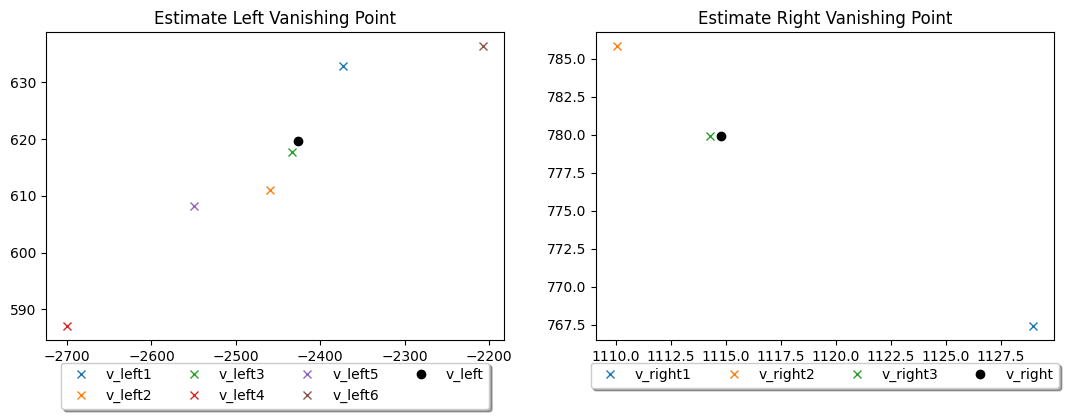

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4))  # 1 row, 2 columns

## LEFT PLOT
ax = axes[0]
# Vanishing points:
for n, p in v_left_all.items():
    ax.plot(p[0], p[1], 'x', label=n)
ax.plot(v_left[0], v_left[1], 'o', ms = 6, label='v_left', color='k')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=4)
ax.set_title("Estimate Left Vanishing Point")

## RIGHT PLOT
ax = axes[1]
# Vanishing points:
for n, p in v_right_all.items():
    ax.plot(p[0], p[1], 'x', label=n)
ax.plot(v_right[0], v_right[1], 'o', ms= 6, label='v_right', color='k')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=8)
ax.set_title("Estimate Right Vanishing Point")

# Show both plots together
plt.show()

### Step 3: Compute the Horizon Line

Once we have the two horizontal vanishing points, the horizon line  is computed as the line passing through them:

$\ell_{\text{horiz}} = v_{\text{left}} \times v_{\text{right}}$

This line represents the set of all points at eye level in the image and is essential for height estimation.

In [17]:
horiz = passing_line(v_left, v_right)

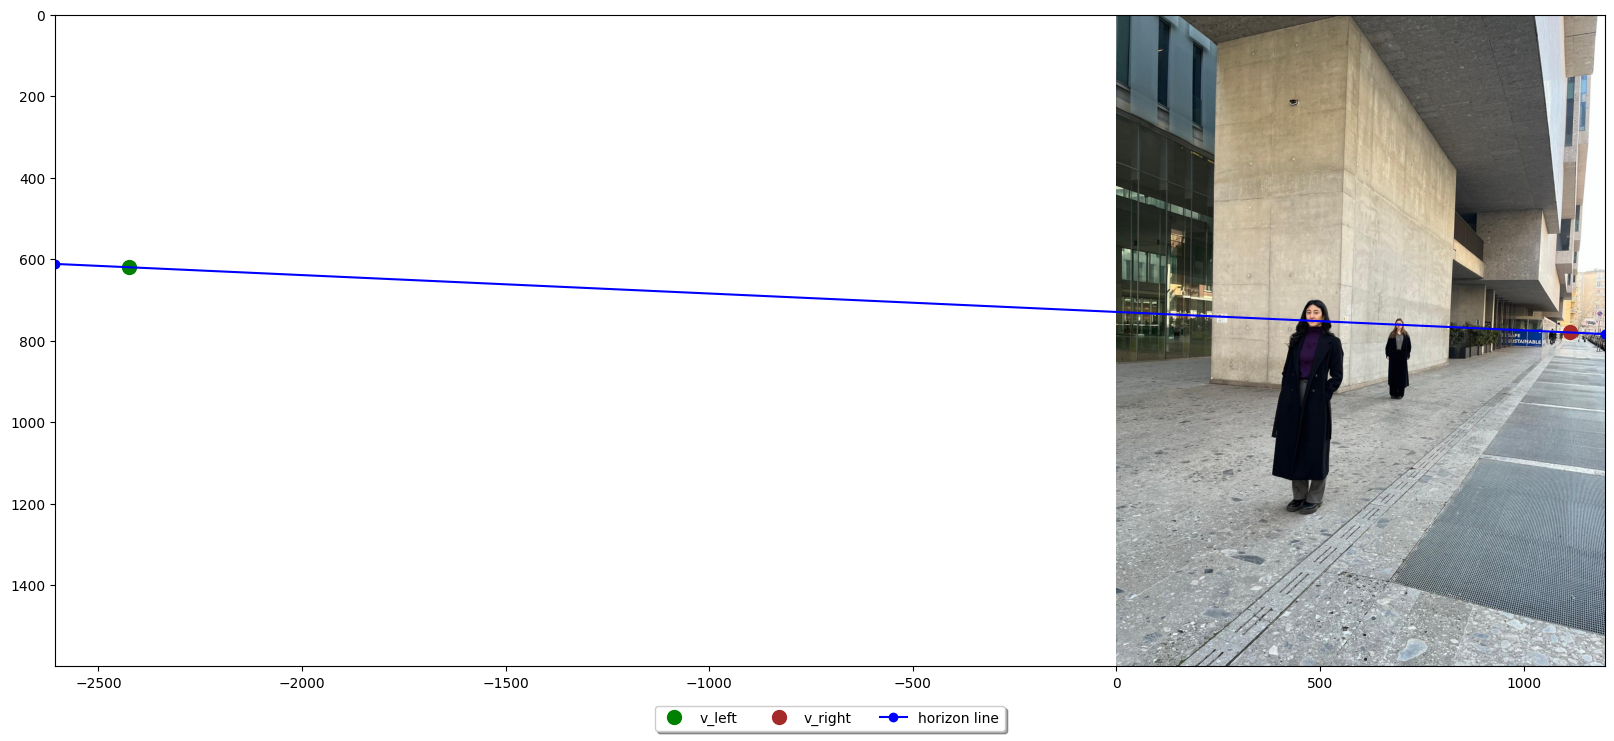

In [21]:
img = cv2.imread('foto.jpg')[:,:,::-1]
plt.figure(figsize=(20,10))
plt.imshow(img)


plt.plot(v_left[0], v_left[1], 'o', ms= 10, label='v_left', color='g')
plt.plot(v_right[0], v_right[1], 'o', ms= 10, label='v_right', color='brown')
plt.axline(xy1= (v_left[0], v_left[1]), xy2= (v_right[0], v_right[1]), marker = 'o', color='blue', label='horizon line')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=8)
plt.show()

## Computing the Height of the Target Subject

With the fundamental projective geometry constructs established, including the vanishing points and the horizon line, we now proceed to estimate the height of the target subject by exploiting additional properties of projective transformations.

One crucial aspect to consider is that the reference subject and the target subject are positioned at different depths relative to the camera. As a result, their perceived heights in the image are subject to perspective distortion. A naive approach based on direct Euclidean distance ratios in the image could lead to inexact results, as Euclidean distances in the image plane do not accurately reflect true distances in 3D space.

To make a valid comparison, we conceptually align the target subject with the reference subject at the same depth. This process effectively removes the influence of perspective distortion, allowing for a meaningful height estimation. The horizon line is fundamental to achieving this alignment.

### Establishing a Common Ground Line

To estimate the height of the target subject, we first informally define the *ground line*, which is a line passing through the feet of both the reference and target subjects:

We obtain it as: $\ell_{\text{ground}} = F_{\text{ref}}\times F_{\text{target}}$ and extend it to determine the intersection point with the horizon line.

We call this point: $U = \ell_{\text{ground}}\times \ell_{\text{horiz}}$

The intersection point $U$ can be understood as the point where the extension of this ground alignment meets the horizon, indicating the vanishing direction of objects receding along the ground.
The correctness of this approach is justified by the picture setup, as both subjects are standing on the same floor level.

From a practical standpoint in computer vision, $U$ allows us to correctly align the target subject’s foot projection with that of the reference subject, ensuring that the subsequent height comparison accounts for perspective effects.

In [ ]:
ground_line = np.cross(F_m, F_c)
U = inters_point(ground_line, horiz)

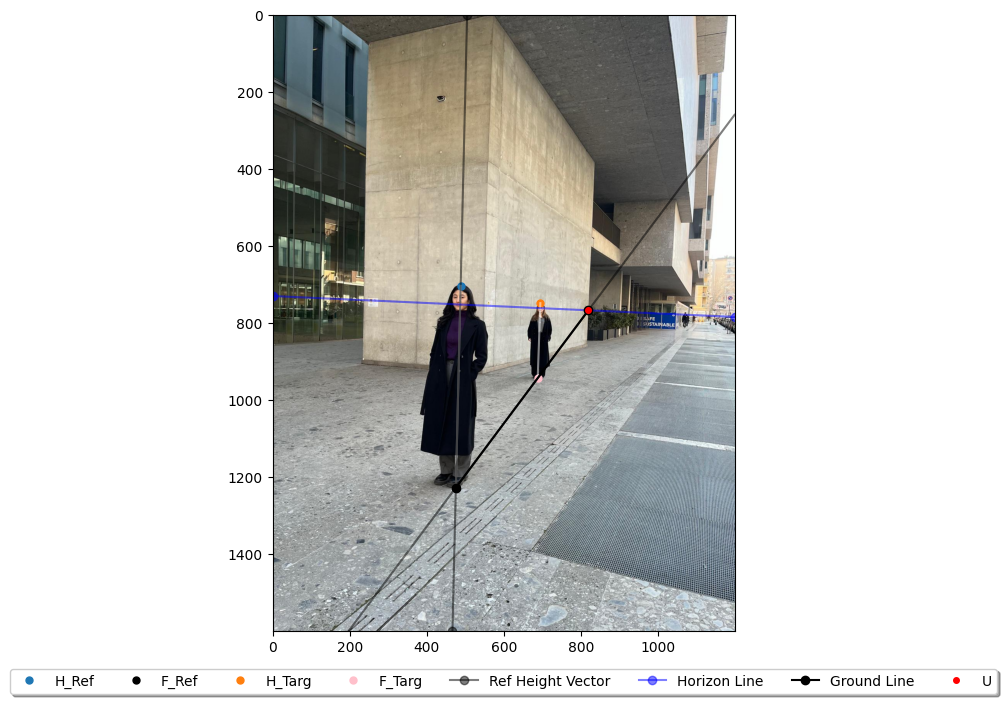

In [ ]:
img = cv2.imread('foto.jpg')[:,:,::-1]
plt.figure(figsize=(10,8))
plt.imshow(img)

# Martina
plt.plot(H_m[0], H_m[1], 'o', label='H_Ref', ms=5)
plt.plot(F_m[0], F_m[1], 'o', label='F_Ref', color= 'k', ms=5)
plt.plot([H_m[0], F_m[0]], [H_m[1], F_m[1]], 'w', alpha=0.5)

# Clara
plt.plot(H_c[0], H_c[1], 'o', label='H_Targ', ms=5)
plt.plot(F_c[0], F_c[1], 'o', label='F_Targ', ms=5, color='pink')
plt.plot([H_c[0], F_c[0]], [H_c[1], F_c[1]], 'w', alpha=0.5)

## vertical lines and vanishing point:
plt.axline(xy1= (H_m[0], H_m[1]), xy2= (F_m[0], F_m[1]), color='k', alpha = 0.5, marker= 'o', label= 'Ref Height Vector')
#plt.axline(xy1= (H_c[0], H_c[1]), xy2= (F_c[0], F_c[1]), color='k', alpha =0.5)


# cropped horizon:
m = (v_right[1] - v_left[1]) / (v_right[0] - v_left[0])
c = v_left[1] - m * v_left[0]
x_left, y_left = 0, c
plt.axline(xy1 = (x_left, y_left), xy2= (v_right[0], v_right[1]), color='blue', alpha=0.5, marker='o', label= 'Horizon Line')


# Ground line:
plt.axline(xy1= (F_m[0], F_m[1]), xy2=(F_c[0], F_c[1]), color='k', alpha=0.5)
plt.plot([F_m[0], U[0]], [F_m[1], U[1]], color='k', marker='o', label='Ground Line')
plt.plot(U[0], U[1], 'o', color= 'r', ms= 4, label = 'U')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=8)

plt.show()

### Aligning the Target Subject with the Reference Subject
To further align the two subjects in the image plane, we construct the projection line, which passes through $U$ and the top key point of the target subject. We call this line $\ell_{\text{proj}}=U \times H_{\text{targ}}$.

We then compute the intersection of this projection line with the height vector of the reference subject, giving us point $I=\ell_{\text{proj}} \times \ell_{\text{ref}}$.
\
\
\
*Remark:* It is important to clarify that we are not just projecting one height vector onto another as we would do in an Euclidean space. Instead, we are leveraging projective geometry to establish a geometric alignment between the two subjects. The intersection point does not represent a direct projection (e.g. orthogonal), but rather a reference point that allows for a correct comparison of the heights of the two subjects under equivalent perspective conditions. This ensures that the height estimation accounts for differences in depth and relative scale.

In [ ]:
proj_line = passing_line(U, H_c)
line_m = passing_line(H_m, F_m)

I = inters_point(line_m, proj_line)

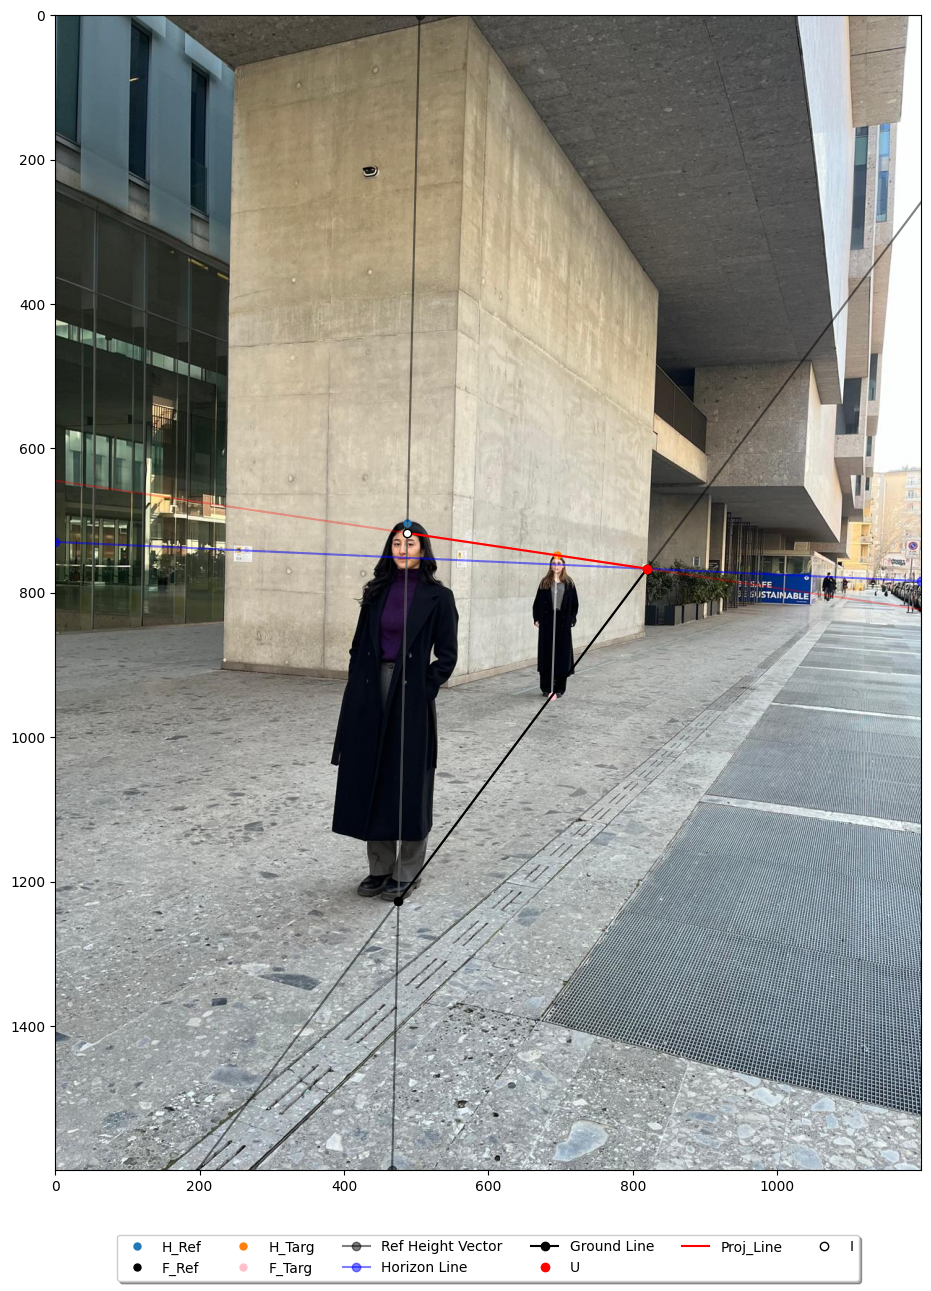

In [ ]:
img = cv2.imread('foto.jpg')[:,:,::-1]
plt.figure(figsize=(20,15))
plt.imshow(img)

# Martina
plt.plot(H_m[0], H_m[1], 'o', label='H_Ref', ms=5)
plt.plot(F_m[0], F_m[1], 'o', label='F_Ref', color= 'k', ms=5)
plt.plot([H_m[0], F_m[0]], [H_m[1], F_m[1]], 'w', alpha=0.5)

# Clara
plt.plot(H_c[0], H_c[1], 'o', label='H_Targ', ms=5)
plt.plot(F_c[0], F_c[1], 'o', label='F_Targ', ms=5, color='pink')
plt.plot([H_c[0], F_c[0]], [H_c[1], F_c[1]], 'w', alpha=0.5)

## vertical lines and vanishing point:
plt.axline(xy1= (H_m[0], H_m[1]), xy2= (F_m[0], F_m[1]), color='k', alpha = 0.5, marker= 'o', label= 'Ref Height Vector')
#plt.axline(xy1= (H_c[0], H_c[1]), xy2= (F_c[0], F_c[1]), color='k', alpha =0.5)


# cropped horizon:
m = (v_right[1] - v_left[1]) / (v_right[0] - v_left[0])
c = v_left[1] - m * v_left[0]
x_left, y_left = 0, c
plt.axline(xy1 = (x_left, y_left), xy2= (v_right[0], v_right[1]), color='blue', alpha=0.5, marker='o', label= 'Horizon Line')


# Ground line:
plt.axline(xy1= (F_m[0], F_m[1]), xy2=(F_c[0], F_c[1]), color='k', alpha=0.5)
plt.plot([F_m[0], U[0]], [F_m[1], U[1]], color='k', marker='o', label='Ground Line')
plt.plot(U[0], U[1], 'o', color= 'r', label = 'U')

# proj_line
plt.axline(xy1= (H_c[0], H_c[1]), xy2= (U[0], U[1]), color = 'r', alpha =0.3)
plt.plot([I[0], U[0]], [I[1], U[1]], color='r', label ='Proj_Line')
plt.plot(I[0], I[1], 'o', color='w', ms= 6, label ='I', markeredgecolor='k')



plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=6)

plt.show()

### Applying the Cross-Ratio for Height Estimation

At the end of the algorithm, we observe that four key points lie along the reference subject’s vertical height line $\ell_{\text{ref}}$:
- $H_{\text{ref}}$
- $I$
- $F_{\text{ref}}$
- $v_{\text{vert}}$

The vertical vanishing point $v_{\text{vert}}$ is not shown as it lies well below the image.

These four points are collinear, since they all lie on the same line $\ell_{\text{ref}}$.
- $H_{\text{ref}}$, $F_{\text{ref}} \in \ell_{\text{ref}}$ trivially by construction.
- $I$ is the point where $\ell_{\text{proj}}$ intersects $\ell_{\text{ref}}$ too, thus trivially lying on it too

One can check whether the estimated vertical vanishing point at infinity $v_{\text{vert}}$ is robust enough to avoid significant deviations from this vertical line:

In [ ]:
print(f"{np.inner(H_m, line_m)=}")
print(f"{np.inner(F_m, line_m)=}")
print(f"{np.inner(I, line_m)=}")
print(f"{np.inner(v_vert, line_m)=}")

np.inner(H_m, line_m)=np.float64(5.820766091346741e-11)
np.inner(F_m, line_m)=np.float64(5.820766091346741e-11)
np.inner(I, line_m)=np.float64(0.0)
np.inner(v_vert, line_m)=np.float64(-0.061707970569841564)


We leverage now the *cross ratio*, that was previously introduced as an invariant property of projective transformations for collinear points.

We see that the following relation holds:

$$\frac{\|I - F_{\text{ref}}\| \| v_{\infty} - H_{\text{ref}}\|}{\|H_{\text{ref}} -F_{\text{ref}}\| \|v_\infty - I\|} = \frac{\frac{\|I - F_{\text{ref}}\|}{\|v_\infty - I\|}}{\frac{\|H_{\text{ref}} -F_{\text{ref}}\|}{\| v_{\infty} - H_{\text{ref}}\|}}=\frac{\hat{h_{\text{targ}}}}{h_{\text{ref}}}$$

\\


Then, $$\hat{h_{\text{targ}}} = h_{\text{ref}} \frac{\|I - F_{\text{ref}}\| \| v_{\infty} - H_{\text{ref}}\|}{\|H_{\text{ref}} -F_{\text{ref}}\| \|v_\infty - I\|} $$

We now proceed with the estimation:

In [ ]:
marti_height = 170
cross_ratio = (np.linalg.norm(I-F_m) * np.linalg.norm(v_vert-H_m)) / (np.linalg.norm(H_m-F_m) * np.linalg.norm(v_vert-I))

clara_height = marti_height * cross_ratio
print(f"Target Height: {clara_height:.2f}cm")

Target Height: 165.53cm


## Limitations and Conclusion
By leveraging vanishing points, the horizon line, and projective invariants, we successfully estimated the true height of the target subject using projective geometry. The computed height can be validated by comparing it with the actual known height of the target subject, and as it closely matches the true value, it confirms the validity of our approach.

However, there are a few centimeters of inaccuracy due to potential imprecisions in the manual annotation of key points. Small deviations in selecting points such as head and foot positions can propagate through the calculations, leading to slight variations in the final estimated height. Despite these minor inaccuracies, the method remains a powerful and rigorous approach to height estimation using single-view metrology, demonstrating its effectiveness in real-world applications.